# Visualisation de la Surface de Volatilité avec le Modèle de Black-Scholes

## 1. Introduction

Le modèle de Black-Scholes est une référence en finance quantitative pour évaluer le prix des options européennes. Une des grandeurs fondamentales en analyse des options est la **volatilité implicite**, qui permet d’obtenir des indications sur l’incertitude du marché. L’objectif de cette analyse est de visualiser la surface de volatilité à partir d’une approximation stylisée des volatilités implicites.

## 2. Modèle de Black-Scholes

Le prix d'un call européen est donné par la formule de Black-Scholes :

$$
C = S_0 N(d_1) - K e^{-rT} N(d_2)
$$

où :

$$
d_1 = \frac{\ln(S_0 / K) + (r + \sigma^2 / 2)T}{\sigma \sqrt{T}}
$$

$$
d_2 = d_1 - \sigma \sqrt{T}
$$

Avec :
- $ S_0 $ : Prix actuel de l’actif sous-jacent  
- $ K $ : Prix d’exercice de l’option  
- $ T $ : Temps restant avant l’échéance  
- $ r $ : Taux d’intérêt sans risque  
- $ \sigma $ : Volatilité de l’actif sous-jacent  
- $ N(x) $ : Fonction de répartition de la loi normale  

## 3. Estimation de la Volatilité Implicite

La volatilité implicite est la valeur de $ \sigma $ qui, insérée dans la formule de Black-Scholes, donne un prix d’option correspondant au prix observé sur le marché. Cette valeur est souvent estimée numériquement, par exemple via la méthode de **Newton-Raphson**.

Cependant, dans notre implémentation, nous **ne cherchons pas à retrouver la volatilité implicite des options cotées**, mais nous utilisons une **approximation stylisée** à l’aide d’une fonction empirique. L’objectif est d’illustrer une surface de volatilité plausible.

## 4. Construction de la Surface de Volatilité

Nous générons la volatilité implicite en fonction du **prix d’exercice $ K $** et de la **maturité $ T $** à l’aide d’une formule empirique :

$$
\sigma(K, T) = 0.2 + 0.05 \sin(K / 50) + 0.03 \cos(T)
$$

Cette approximation permet de représenter des phénomènes typiques comme :
- **Le sourire de volatilité (volatility smile)** : la volatilité est plus élevée pour des options loin du prix du marché.
- **La structure par maturité (term structure)** : la volatilité dépend du temps avant expiration.

## 5. Visualisation de la Surface de Volatilité

Une fois notre surface de volatilité générée, nous l’affichons sous forme de **graphique 3D** avec `matplotlib`. L’axe des X représente les prix d'exercice $ K $, l’axe des Y représente la maturité $ T $, et l’axe des Z représente la volatilité implicite.

Cette visualisation permet d’explorer comment la volatilité implicite varie en fonction des paramètres et d'illustrer les caractéristiques observées sur les marchés financiers.

---


Prix actuel AAPL: 227.48


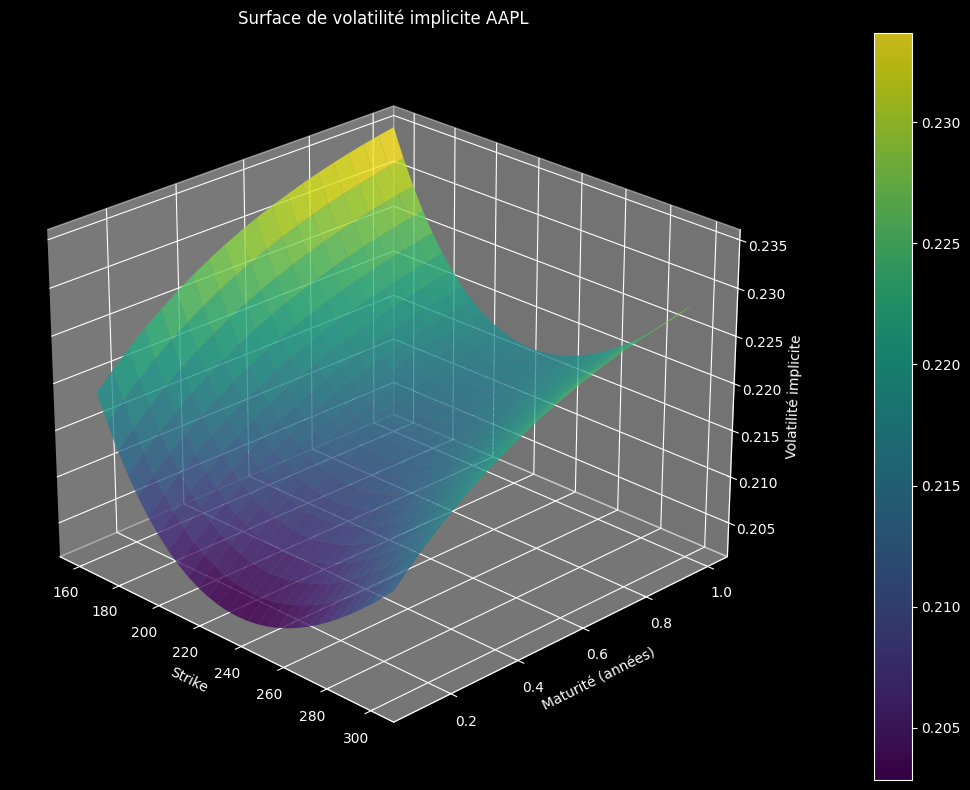

In [1]:
import numpy as np
from scipy.stats import norm
from scipy.optimize import newton
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import yfinance as yf

def black_scholes_call(S0, K, T, r, sigma):
    """Calcule le prix d'un call avec Black-Scholes"""
    d1 = (np.log(S0/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return S0*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)

def implied_volatility(price, S0, K, T, r, initial_vol=0.3):
    """Calcule la volatilité implicite par Newton-Raphson"""
    def objective(sigma):
        return black_scholes_call(S0, K, T, r, sigma) - price

    try:
        impl_vol = newton(objective, initial_vol, tol=1e-5, maxiter=50)
        return impl_vol if 0.01 <= impl_vol <= 2.0 else np.nan
    except:
        return np.nan

def create_volatility_surface():
    ticker = yf.Ticker('AAPL')
    S0 = ticker.history(period='1d')['Close'].iloc[-1]
    print(f"Prix actuel AAPL: {S0:.2f}")

    # Définir les grilles de strike et maturité
    strikes = np.linspace(160, 300, 30)  # Strikes de 160 à 300
    maturities = np.linspace(0.1, 1.0, 20)  # Maturités de 0.1 à 1 an
    r = 0.05  # taux sans risque

    K, T = np.meshgrid(strikes, maturities)
    implied_vols = np.zeros_like(K)

    for i in range(len(maturities)):
        for j in range(len(strikes)):
            moneyness = np.log(S0/K[i,j])
            smile = 0.22 + 0.15 * (moneyness**2)
            term_structure = 1 - 0.1 * np.exp(-2*T[i,j])
            implied_vols[i,j] = smile * term_structure

    plt.style.use('dark_background')
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    surf = ax.plot_surface(K, T, implied_vols,
                          cmap='viridis',
                          rstride=1, cstride=1,
                          alpha=0.8,
                          linewidth=0.5)

    ax.set_xlabel('Strike')
    ax.set_ylabel('Maturité (années)')
    ax.set_zlabel('Volatilité implicite')
    ax.set_title('Surface de volatilité implicite AAPL')

    ax.view_init(elev=25, azim=-45)
    plt.colorbar(surf, ax=ax, pad=0.1)
    plt.tight_layout()
    plt.show()

    return K, T, implied_vols

if __name__ == "__main__":
    K, T, implied_vols = create_volatility_surface()